# Introduction

We hear about celebrity breakups almost every day. I’m curious about if celebrities have a higher divorce rate than the general population? If so, how high their divorce rate could be? How long are their marriages last? What’s the key reason to drive their divorces? Has it changed over time? Is it predictable?


This notebook will dive into the top actors data parsed from [Imdb](https://www.imdb.com/list/ls058011111/?sort=list_order,asc&mode=detail&page=1) and try to provide insights on the celebrities marriage and divorce by analyzing these data.


In the end, we'll use simple [classification model](https://en.wikipedia.org/wiki/Statistical_classification) to show how predictable marriages between top actors and actresses can be.


# Project Set-Up

## Import Data

In [1]:
# Import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import math

In [2]:
# Importing data
# Import data from Top Actor list.
df = pd.read_csv('d12020.csv', na_values = '-1')
df.head()

,Unnamed: 0,celeb_bd,partner_bd,celeb_nominated,partner_nominated,marriage_status,celeb_gender,partner_gender
0,Grace Hightower / Robert De Niro,1943-8-17,1955-4-7,True,False,\n(17 June 1997 - \npresent) ( s...,Male,Female
1,Diahnne Abbott / Robert De Niro,1943-8-17,1945-5-1,True,False,\n(28 April 1976 - \n1988) ( div...,Male,Female
2,Sandra Knight / Jack Nicholson,1937-4-22,1939-9-2,True,False,\n(17 June 1962 - \n8 August 1968) ...,Male,Female
3,Tarita / Marlon Brando,1924-4-3,1941-12-29,True,True,\n(10 August 1962 - \n14 July 1972)...,Male,Female
4,Movita / Marlon Brando,1924-4-3,1916-4-12,True,False,\n(4 June 1960 - \n1962) ( divor...,Male,Female


## Data Cleaning and Feature Extraction

So, we've a dataset containing the marriage details of different actors.

In this section, we'll work on things we can improve on in the dataset.

* Cleaning of messy features.
* Check Uniformity of categorical variables.
* Assess missing values.
* Feature Extraction.
* Asses Data types and Duplicate values.




### Cleaning of messy features

There are several features that need to be put in better condition before analysis:

* Separate celebrity and his/her partner names into different columns.
* Put the features in an order that make sense with respect to our analysis.
* Clean and Extract useful information from 'marriage_status' column.



    

In [3]:
# Separate celebrity and partner column names
df['Partner/Celebrity'] = df.iloc[:, 0]
df.drop(df.columns[0], axis = 1, inplace = True)
df['celeb_name'] = df['Partner/Celebrity'].apply(lambda x: x.split('/')[1])
df['partner_name'] = df['Partner/Celebrity'].apply(lambda x: x.split('/')[0])
df.drop(df.columns[-3], axis = 1, inplace = True )
df.head()

,celeb_bd,partner_bd,celeb_nominated,partner_nominated,marriage_status,celeb_gender,partner_gender,celeb_name,partner_name
0,1943-8-17,1955-4-7,True,False,\n(17 June 1997 - \npresent) ( s...,Male,Female,Robert De Niro,Grace Hightower
1,1943-8-17,1945-5-1,True,False,\n(28 April 1976 - \n1988) ( div...,Male,Female,Robert De Niro,Diahnne Abbott
2,1937-4-22,1939-9-2,True,False,\n(17 June 1962 - \n8 August 1968) ...,Male,Female,Jack Nicholson,Sandra Knight
3,1924-4-3,1941-12-29,True,True,\n(10 August 1962 - \n14 July 1972)...,Male,Female,Marlon Brando,Tarita
4,1924-4-3,1916-4-12,True,False,\n(4 June 1960 - \n1962) ( divor...,Male,Female,Marlon Brando,Movita


In [4]:
# Re-arranging columns
cols = df.columns.tolist()
cols = cols[-2:] + cols[:-2]
df = df[cols]
df.tail(9)

,celeb_name,partner_name,celeb_bd,partner_bd,celeb_nominated,partner_nominated,marriage_status,celeb_gender,partner_gender
1350,Olivia Colman,Ed Sinclair,1974-1-30,NaN,True,False,\n(August 2001 - \npresent) ( 3 ...,Female,Male
1351,Mireille Enos,Alan Ruck,1975-9-22,1956-7-1,True,False,\n(4 January 2008 - \npresent) ( ...,Female,Male
1352,Jennifer Love Hewitt,Brian Hallisay,1979-2-21,1978-10-31,True,False,\n(20 November 2013 - \npresent) ( ...,Female,Male
1353,Emmy Rossum,Sam Esmail,1986-9-12,1977-9-17,True,False,\n(28 May 2017 - \npresent),Female,Male
1354,Emmy Rossum,Justin Siegel,1986-9-12,NaN,True,False,\n(17 February 2008 - \n28 December...,Female,NaN
1355,Ginnifer Goodwin,Josh Dallas,1978-5-22,1978-12-18,False,False,\n(12 April 2014 - \npresent) ( ...,Female,NaN
1356,Christine Taylor,Ben Stiller,1971-7-30,1965-11-30,False,False,\n(13 May 2000 - \npresent) ( fi...,Female,Male
1357,Kate Capshaw,Steven Spielberg,1953-11-3,1946-12-18,False,True,\n(12 October 1991 - \npresent) ( ...,Female,Male
1358,Kate Capshaw,Robert Capshaw,1953-11-3,NaN,False,False,\n(January 1976 - \n1980) ( divo...,Female,NaN


In [5]:
# Breaking marriage status column into [marriage_data, marriage_end, status, children] columns
import re
df.marriage_status = df['marriage_status'].apply(lambda x: x.replace('\n', '').split(')\xa0'))
df['marriage_date'] = df['marriage_status'].apply(lambda x: x[0].replace('\xa0','').split('-')[0].strip('(') )
df['marriage_end'] = df['marriage_status'].apply(lambda x: x[0].replace('\xa0','').split('-')[1] )
df.marriage_status = df.marriage_status.apply(lambda x :  x + ['present'] if len(x) == 1 else x)
df['status'] = df['marriage_status'].apply(lambda x: x[1].strip('(').strip(')') if any(word in x[1] for word in ['separated', 'divorce', 'death', 'annulled'])
                                           else 'present')
df.marriage_status= df.marriage_status.apply(lambda x: x + ['0'] if len(x) == 2 and 
                                             any(word in x[1] for word in ['separated', 'divorce', 'death',
                                                                           'annulled', 'present']) else x)
df.marriage_status = df.marriage_status.apply(lambda x : x[:1] + ['present'] + x[1:] if 'present' in x[0] and 'child' in x[1] else x)
df['children'] = df.marriage_status.apply(lambda x: re.search('\d', x[2]).group() if  any(word in x[1] for word in ['separated', 'divorce', 'death',
                                                                                      'present', 'annulled']) 
                                      else re.search('\d', x[1]).group()
                                      ) 

### Categorical Variables Uniformity

Check categorical uniformity for all categorical features and dates, then deal with any issues that could have appeared due to dealing with messy text data.

Features of interest:

* marriage_date
* marriage_end
* status
* children



In [6]:
df['marriage_date'].value_counts()

?                              14
1987                            9
1915                            4
1966                            4
2003                            3
                               ..
4 May1996                       1
24 January2001                  1
2 June2020                      1
27 December1980                 1
31 December1940                 1
Name: marriage_date, Length: 1210, dtype: int64

In [7]:
df['marriage_end'].value_counts()

 present               260
 present)               80
 ?                      11
 1992                   10
 1996                    9
                      ... 
 23 February1997         1
 29 January1940          1
 29 January2004          1
 10 January1936          1
 21 September1960        1
Name: marriage_end, Length: 786, dtype: int64

In [8]:
df['status'].value_counts()

    divorced                        397
    divorced)                       381
present                             320
    his death                        83
    his death)                       76
    her death)                       33
    her death                        33
    filed for divorce                13
    annulled)                        11
    separated                         6
    separated)                        3
    filed for divorce)                2
    annulled                          1
Name: status, dtype: int64

In [9]:
df['children'].value_counts()

0    589
1    327
2    294
3    106
4     28
5      7
6      6
7      1
8      1
Name: children, dtype: int64

Features that either hold categories or dates hold inconsistent data:

* Categories: Inconsistent categories due to trailing spaces and meaningless distinguishes with respect to our analysis. (status, marriage_end)

Approach : We'll approach the solution with text data operations to eliminate these differences and unify all categories.


* Dates: Inconsistent date formats. (marriage_date, marriage_end)

Appraoch :  We're more interested to know in which year did the marriage happened compared to knowing its exact date; so that's the form that we'll unify all of the contents upon.

In [10]:
# Stripping trailing spaces and brackets from text data
df['marriage_date'] = df['marriage_date'].apply(lambda x : x.strip())
df['celeb_name'] = df['celeb_name'].apply(lambda x : x.strip())
df['partner_name'] = df['partner_name'].apply(lambda x : x.strip())
df['marriage_end'] = df['marriage_end'].apply(lambda x : x.strip())
df['marriage_end'] = df['marriage_end'].apply(lambda x : x.strip(')'))
df['status'] = df['status'].apply(lambda x : x.strip())
df['status'] = df['status'].apply(lambda x : x.strip(')'))

In [11]:
# Method used to get year out of inconsistent date formats
def get_year(x):
    x = re.search('[0-9][0-9][0-9][0-9]', str(x))
    if x == None:
        return np.nan
    else:
        x = x.group()
        return int(x)
    

In [12]:
df['celeb_bd'] = df['celeb_bd'].apply(lambda x: get_year(x))
df['partner_bd'] = df['partner_bd'].apply(lambda x: get_year(x))
df['marriage_date'] = df['marriage_date'].apply(lambda x: get_year(x))
df['marriage_end'] = df['marriage_end'].apply(lambda x : get_year(x))
df['children'] = df['children'].astype('int')
del df['marriage_status']

In [13]:
presents = df.loc[df['status'] == 'present', 'marriage_end']
presents[presents.isnull()] = 'present'
df.loc[df['status'] == 'present', 'marriage_end'] = presents

In our analysis, we' re interested in how marriages between actors ends and we'll assume that there are two ways a marriage can end,  either with a divorce or with no divorce. So, we'll assume that categories like (separated, filed for divorce) as divorce end to the marriage, and those marriages that are either (present, ended due to death of one partner) as no divorce.



In [14]:
mapping = { 'filed for divorce': 'divorced', 'separated': 'divorced','(divorced) 2 children': 'divorced'}
df['status'] = df['status'].replace(mapping)
df['status'].value_counts()

divorced     802
present      320
his death    159
her death     66
annulled      12
Name: status, dtype: int64

### Assessing missing values



We want to make sure that all forms of missing data is described with nan values to be able to identify, analyze and deal with it. Imdb site use '?' to denote data that is missing there, since it's the place we got our data from; we replace following expressions with nan value with the help of numpy library.

In [16]:
# Represent missing values as nan
df = df.replace(['?', '199?'], np.nan)

In [17]:
# Summary of missing values all represented as NANs
df.isnull().sum()

celeb_name             0
partner_name           6
celeb_bd               0
partner_bd           479
celeb_nominated        0
partner_nominated      0
celeb_gender           0
partner_gender       439
marriage_date         16
marriage_end          35
status                 0
children               0
dtype: int64

The following plot helps us locate missing values in each feature and get idea on where, and why this missing values appear:

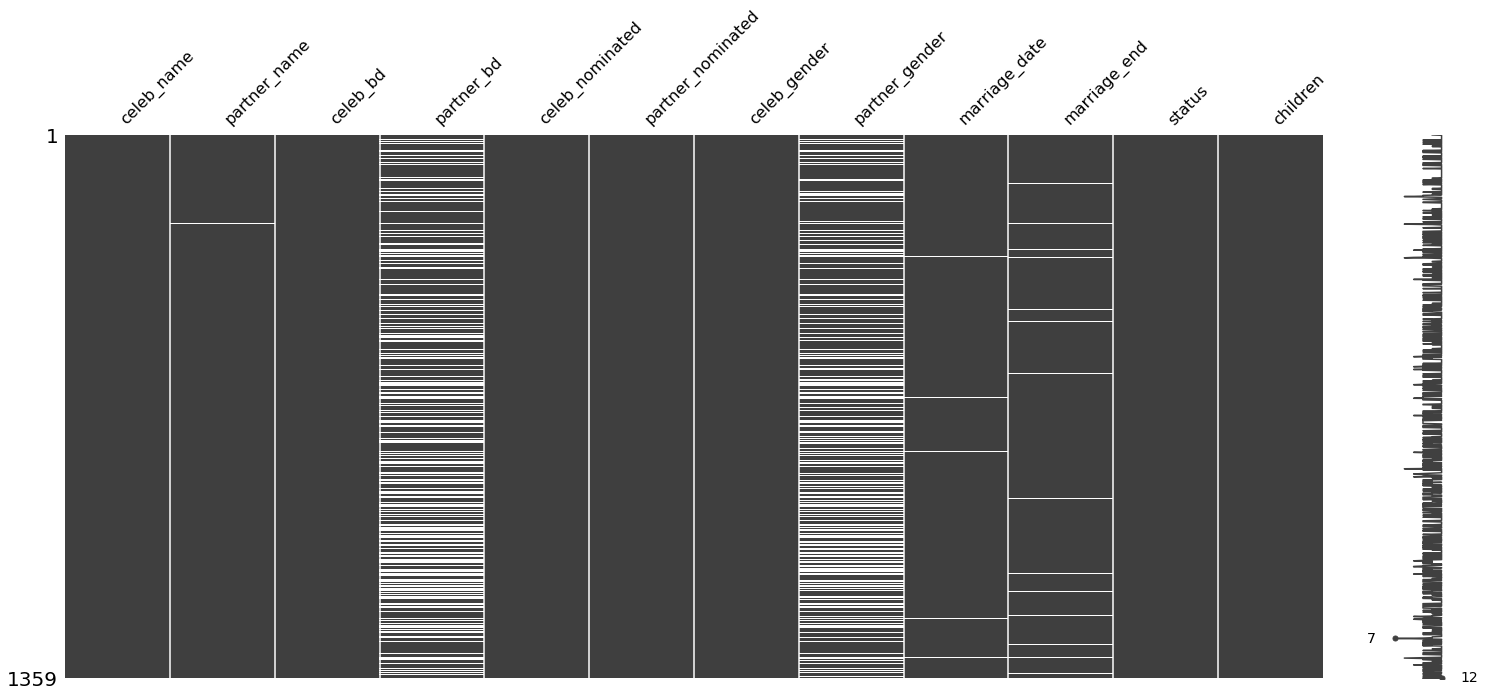

In [18]:
import missingno as msno
# Visualize missingness
msno.matrix(df)
plt.show()

We see a lot of missing values in columns (partner_bd and partner_gender) this happens when celebrites are married to people outside of the acting field; thus they don't have profiles on imdb. This fact holds information that could be of use to our analysis as it helps us distinguish which partners are in the acting field.

Also there are some missing values in (marriage_start and marriage_end) columns. Marriages that have missing values of marriage_date and marriage_end would be hard to analyze; as it's diffuclt to find a sensible way to impute such values. Also, they only possess less than 5% of the data so there will be little to no effect to completely dropping these values

In [19]:
df.dropna(axis = 0, subset = ['marriage_date', 'marriage_end', 'partner_name'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1310 entries, 1 to 1358
Data columns (total 12 columns):
celeb_name           1310 non-null object
partner_name         1310 non-null object
celeb_bd             1310 non-null int64
partner_bd           858 non-null float64
celeb_nominated      1310 non-null bool
partner_nominated    1310 non-null bool
celeb_gender         1310 non-null object
partner_gender       896 non-null object
marriage_date        1310 non-null float64
marriage_end         1310 non-null object
status               1310 non-null object
children             1310 non-null int64
dtypes: bool(2), float64(2), int64(2), object(6)
memory usage: 115.1+ KB


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1310 entries, 1 to 1358
Data columns (total 12 columns):
celeb_name           1310 non-null object
partner_name         1310 non-null object
celeb_bd             1310 non-null int64
partner_bd           858 non-null float64
celeb_nominated      1310 non-null bool
partner_nominated    1310 non-null bool
celeb_gender         1310 non-null object
partner_gender       896 non-null object
marriage_date        1310 non-null float64
marriage_end         1310 non-null object
status               1310 non-null object
children             1310 non-null int64
dtypes: bool(2), float64(2), int64(2), object(6)
memory usage: 115.1+ KB


We see that still there're some missing values in (partner_bd. partner_gender, partner_name) columns.

In [21]:
# Addressing Partner_gender missing values
df['partner_gender'] = df['celeb_gender'].apply(lambda x: 'Male' if 'Female' in x  else 'Female')

In [22]:
df.isnull().any()

celeb_name           False
partner_name         False
celeb_bd             False
partner_bd            True
celeb_nominated      False
partner_nominated    False
celeb_gender         False
partner_gender       False
marriage_date        False
marriage_end         False
status               False
children             False
dtype: bool

### Feature Extraction

In this section, we extract meaningful features for the purpose of our analysis.
* divorced: Indicates whether given marriage ended with divorce (divorced = 1) or not (divorced = 0)
* celeb_age_w_married: Indicates the celebrity age when the marriage started.
* partner_age_w_married: Indicates the partner age when the marriage started.
* age_gap: Indicates the age gap between the celebrity and his/her partner.
* male_older: Indicates who is older. (male_older = 1) when Male partner is older and (male_older = 0) if not.
* celeb_older: Indicates who is older. (celeb_older = 1) when celebrity is older and (celeb_older = 0) if not.
* marriage_len: Indicates the length of the marriage.

In [23]:
# Creating a target variable
df['divorced'] =df['status'].apply(lambda x: 1 if x == 'divorced' else 0)

In [25]:
df['celeb_age_w_married'] = df.apply(lambda x : x['marriage_date'] - x['celeb_bd'], axis = 1)
df['partner_age_w_married'] = df.apply(lambda x : x['marriage_date'] - x['partner_bd'], axis = 1)
df['age_gap'] = df.apply(lambda x : abs(x['celeb_age_w_married'] - x['partner_age_w_married']), axis = 1)
df['male_older'] = df.apply(lambda x: 1 if x['celeb_age_w_married'] > x['partner_age_w_married'] and x['celeb_gender'] == 'Male' else 0, axis = 1)
df['celeb_older'] = df.apply(lambda x: 1 if x['celeb_age_w_married'] > x['partner_age_w_married'] else 0, axis = 1)
df['marriage_len'] = df.apply(lambda x: 2020 -  x['marriage_date'] if x['marriage_end'] == 'present' else x['marriage_end'] - x['marriage_date']  , axis = 1 )

In [27]:
df['partner_in_acting_field'] = ~df['partner_bd'].isnull()

We'll expect a lot of errors in 'partner_age_w_married' feature as we have a lot of missing values in 'partner_bd'that in turn will contribute to errors in the age_gap feature but we'll address that in the coming section.

###  Assess Data Types

Ensure Data types of features are in the correct form for the purpose of our analysis

In [28]:
df.dtypes

celeb_name                  object
partner_name                object
celeb_bd                     int64
partner_bd                 float64
celeb_nominated               bool
partner_nominated             bool
celeb_gender                object
partner_gender              object
marriage_date              float64
marriage_end                object
status                      object
children                     int64
divorced                     int64
celeb_age_w_married        float64
partner_age_w_married      float64
age_gap                    float64
male_older                   int64
celeb_older                  int64
marriage_len               float64
partner_in_acting_field       bool
dtype: object

In [29]:
df['celeb_gender'] = (df['celeb_gender'] == 'Female').astype(int)
df['partner_gender'] = (df['partner_gender'] == 'Female').astype(int)
df['celeb_nominated'] = (df['celeb_nominated'] == True).astype(int)
df['partner_nominated'] = (df['partner_nominated'] == True).astype(int)
df['partner_in_acting_field'] = df['partner_in_acting_field'].astype(int)

In [30]:
df.dtypes

celeb_name                  object
partner_name                object
celeb_bd                     int64
partner_bd                 float64
celeb_nominated              int32
partner_nominated            int32
celeb_gender                 int32
partner_gender               int32
marriage_date              float64
marriage_end                object
status                      object
children                     int64
divorced                     int64
celeb_age_w_married        float64
partner_age_w_married      float64
age_gap                    float64
male_older                   int64
celeb_older                  int64
marriage_len               float64
partner_in_acting_field      int32
dtype: object

### Dealing with missing values

In **section 2.2.3** we assessed missing values and even dealt with some of them which were in (marriage_date, marriage_end) columns. 

Also, we saw that there're a lot of missing values in partner_bd column which resulted missing ones in partner_age_w_married column. We'll solve that by imputing partner's age using the median age gap bet/ween partners.

In [31]:
# Dealing with any errors in dates that might be in data
df.drop(df.index[df[df['partner_bd'] > df['marriage_date']].index], inplace = True)
df.drop(df[df['partner_age_w_married'] < 0 ].index, inplace = True)

In [32]:
df.groupby('partner_gender')['age_gap'].median()

partner_gender
0    5.0
1    6.0
Name: age_gap, dtype: float64

In [33]:
# Replacing age_gap missing value for female partners
filter_female = df.loc[(df['partner_gender'] == 1), 'age_gap']
filter_female.fillna(filter_female.median(), inplace = True)
df.loc[(df['partner_gender'] == 1), 'age_gap'] = filter_female
# Replacing age_gap missing value for male partners
filter_male = df.loc[(df['partner_gender'] == 0), 'age_gap']
filter_male.fillna(filter_male.median(), inplace = True)
df.loc[(df['partner_gender'] == 0), 'age_gap'] = filter_male

In [34]:
# Replaceing partner_age_w_married
df.fillna(value= {'partner_age_w_married': df.celeb_age_w_married - df.age_gap} , axis = 0, inplace = True)
# Dropping partner_bd
df = df.drop(['partner_bd', 'status'], axis = 1)

In [35]:
df.marriage_date = df.marriage_date.astype(int)
df.celeb_age_w_married = df.celeb_age_w_married.astype(int)
df.partner_age_w_married = df.partner_age_w_married.astype(int)
df.age_gap = df.age_gap.astype(int)


### Duplicate Values

Deal with duplicate marriages that may occur due recording one marriage twice with each celebrity taking both roles (celebrity and partner) when two celebrites in the list marry each other.

In [36]:
duplicate = df['partner_name'].apply(lambda x: True if x in list(set(df.celeb_name).intersection(df.partner_name)) else False)
df = df[~duplicate]
df


,celeb_name,partner_name,celeb_bd,celeb_nominated,partner_nominated,celeb_gender,partner_gender,marriage_date,marriage_end,children,divorced,celeb_age_w_married,partner_age_w_married,age_gap,male_older,celeb_older,marriage_len,partner_in_acting_field
1,Robert De Niro,Diahnne Abbott,1943,1,0,0,1,1976,1988,2,1,33,31,2,1,1,12.0,1
2,Jack Nicholson,Sandra Knight,1937,1,0,0,1,1962,1968,1,1,25,23,2,1,1,6.0,1
3,Marlon Brando,Tarita,1924,1,1,0,1,1962,1972,2,1,38,21,17,1,1,10.0,1
4,Marlon Brando,Movita,1924,1,0,0,1,1960,1962,2,1,36,44,8,0,0,2.0,1
5,Marlon Brando,Anna Kashfi,1924,1,0,0,1,1957,1959,1,1,33,23,10,1,1,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,Emmy Rossum,Sam Esmail,1986,1,0,1,0,2017,present,0,0,31,40,9,0,0,3.0,1
1354,Emmy Rossum,Justin Siegel,1986,1,0,1,0,2008,2010,0,1,22,17,5,0,0,2.0,0
1355,Ginnifer Goodwin,Josh Dallas,1978,0,0,1,0,2014,present,2,0,36,36,0,0,0,6.0,1
1357,Kate Capshaw,Steven Spielberg,1953,0,1,1,0,1991,present,5,0,38,45,7,0,0,29.0,1


## EDA

Three questions will be answers in this section:

* What is the divorce rate amongst U.S celebrities in Hollywood compared to the general U.S population?


* Does Divorce Rates  between Actors changed over time? 


* How long is celebrity marriage last?


* Features that have the most impact on celebrity divorce?

### Uni-variate Analysis

#### Diagnosis of target variable


In [39]:
# Separating target variable from features
y = df.divorced
x = df.drop(['divorced'], axis = 1)
y.shape

(1216,)

Number of divorce cases:  697
Number of Non-divorce cases:  519


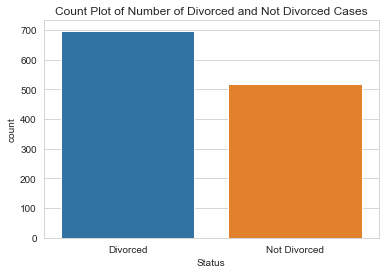

In [54]:
sns.set_style('whitegrid')
ax = sns.countplot(y.map({0:'Not Divorced', 1:'Divorced'}), label = 'Count')
ax.set(title = 'Count Plot of Number of Divorced and Not Divorced Cases',
        xlabel = 'Status')
D, ND = y.value_counts()
print('Number of divorce cases: ', D)
print('Number of Non-divorce cases: ', ND)

We see that there's a class imbalance between the two outcomes of the target variable. But the two classes are not imbalanced in a vigorous way. Class 0 (No divorce) occupies 42% of the cases which approaches the ideal case of 50-50 class balance; so applying synthetic sampling methods is not needed to balance classes.

**What is the divorce rate amongst U.S celebrities in Hollywood compared to the general U.S population?**

According to [2017 US Census data](https://data.census.gov/cedsci/deeplinks?url=https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_17_1YR_S1201&prodType=table), about 23% of married couples in the United States divorce. Among them, the divorce rate for male is 20%, and for female is 26%.
However, the average divorce rate of top Hollywood celebrities is 58%, which is **more than 2 times higher** than the general population. Female has 60% divorce rate, while the divorce rate of male is 55%.

Male      0.549699
Female    0.601449
Name: divorced, dtype: float64


[Text(0, 0.5, 'Divorce Rate'),
 Text(0.5, 0, 'Gender'),
 Text(0.5, 1.0, 'Divorce Rate per Gender between Top Actors')]

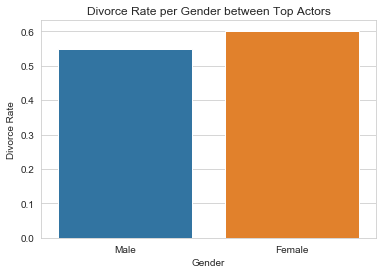

In [112]:
g = df.groupby('celeb_gender')['divorced'].mean()
g.index = ['Male', 'Female']
ax = sns.barplot(x = g.index, y= g.values)
print(g)
ax.set(title = 'Divorce Rate per Gender between Top Actors', xlabel = 'Gender', ylabel = 'Divorce Rate')

#### Feature Diagnosis

##### Numerical Features

We'll start by computing summary statistics on numerical features. Since, we've number of boolean features it's important to distinguish between features that will produce meaningful insight from computing its statistical summary.

In [69]:
# Statistical Summary of the features
num_var = ['celeb_bd', 'celeb_age_w_married', 'partner_age_w_married', 'age_gap', 'marriage_date', 'marriage_len']
x_num = x[num_var]
x_num_np = x_num.values
x_num.describe()

,celeb_bd,celeb_age_w_married,partner_age_w_married,age_gap,marriage_date,marriage_len
count,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000
mean,1938.415296,35.613487,32.045230,7.160362,1974.028783,13.629934
std,26.583068,13.106224,11.515762,6.179065,28.062482,13.357431
min,1868.000000,15.000000,10.000000,0.000000,1894.000000,0.000000
25%,1918.000000,26.000000,24.000000,4.000000,1952.000000,4.000000
50%,1938.000000,32.000000,30.000000,6.000000,1976.000000,9.000000
75%,1960.000000,41.000000,38.000000,8.000000,1998.000000,19.000000
max,1990.000000,87.000000,86.000000,48.000000,2020.000000,66.000000


In [75]:
def dist_plot(variable):
    fig=plt.figure(figsize=(9,3))
    x=df[variable]
    sns.distplot(x, bins = 25, kde=True)
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()

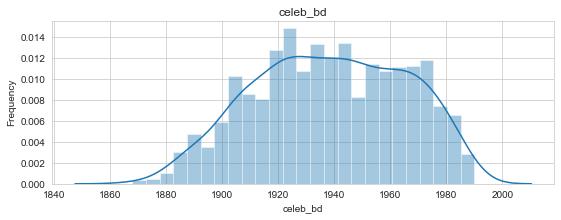

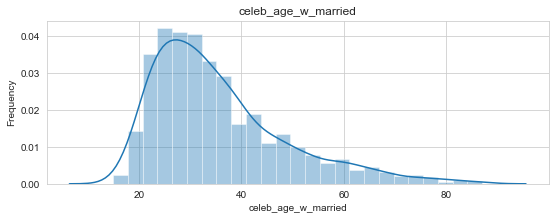

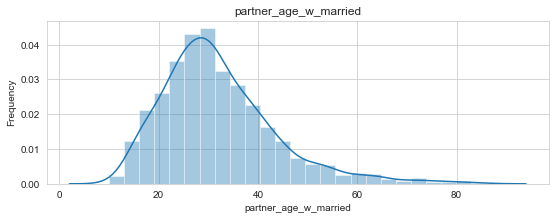

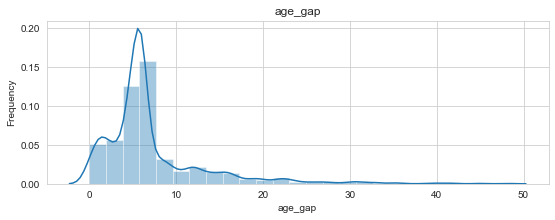

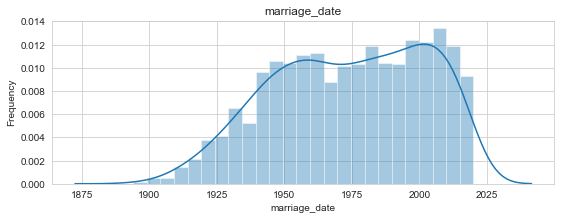

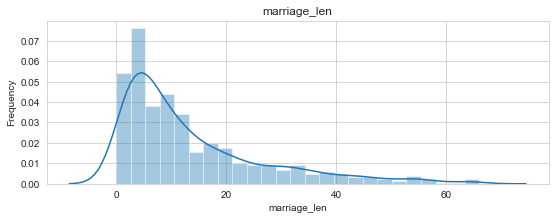

In [76]:
for c in num_var:
    dist_plot(c)

##### Categorical Features

Number of cases when celebrity partner is in the acting field:  765
Number of cases when celebrity partner isn't in the acting field:  451


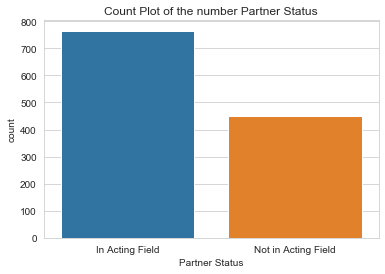

In [62]:
ax = sns.countplot(x.partner_in_acting_field.map({0:'Not in Acting Field', 1:'In Acting Field'}), label = 'count')
ax.set(title = 'Count Plot of the number Partner Status', 
      xlabel = 'Partner Status')
I, NI = df.partner_in_acting_field.value_counts()
print('Number of cases when celebrity partner is in the acting field: ', I)
print('Number of cases when celebrity partner isn\'t in the acting field: ', NI)

[Text(0.5, 1.0, 'Count Plot of the number Children')]

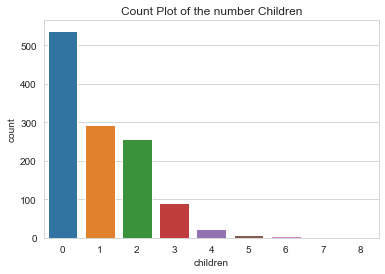

In [77]:
ax = sns.countplot(x.children, label = 'count')
ax.set(title = 'Count Plot of the number Children')

Quick Insights from univarite visualization of features:
    
* Top actors tend to have partners who are in the acting field.
* High proportion of marriages don't result any children, and in rare cases they result more than 2 children.
* Most marriages don't last more than 10 years, and high proportion of marriages don't even last for 5 years.

### Bi-variate Analysis










#### Relationship with Target Variable 

##### Effect of Celebrity Gender on Divorce Rates

Percentage of Divorce per Category:  

Male      0.549699
Female    0.601449
Name: divorced, dtype: float64 


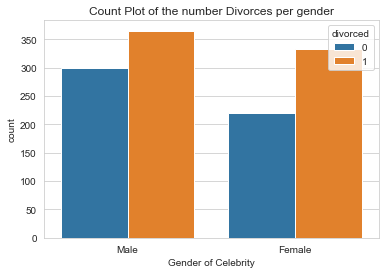

In [111]:
ax = sns.countplot(df.celeb_gender.map({0:'Male', 1:'Female'}), hue = 'divorced', data = df)
ax.set(title = 'Count Plot of the number Divorces per gender', 
      xlabel = 'Gender of Celebrity')

g = df.groupby('celeb_gender')['divorced'].mean()
g.index = ['Male', 'Female']
print(f'Percentage of Divorce per Category:  \n\n{g} ')

##### Effect of Nominations on Divorce Rates

Percentage of Divorce per Category:  

Both       0.686275
Neither    0.537143
One        0.567625
Name: divorced, dtype: float64 


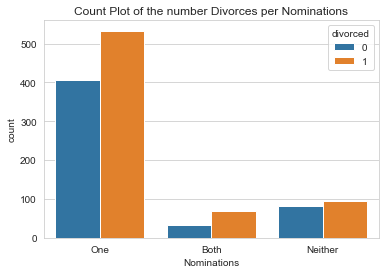

In [109]:
Nominations = df.apply(lambda x: 'Both' if (x['celeb_nominated'] == 1) & (x['partner_nominated'] == 1) else 'One' if x['celeb_nominated'] ^ x['partner_nominated'] else 'Neither', axis = 1)
ax = sns.countplot(x='Nominations', hue = 'divorced', data = df)
ax.set(title = 'Count Plot of the number Divorces per Nominations')

g = df.groupby(Nominations)['divorced'].mean()
print(f'Percentage of Divorce per Category:  \n\n{g} ')

##### Effect of whether Partner in Acting Field on Divorce Rates

Percentage of Divorce per Category:

Not in Acting Field    0.547672
In Acting Field        0.588235
Name: divorced, dtype: float64


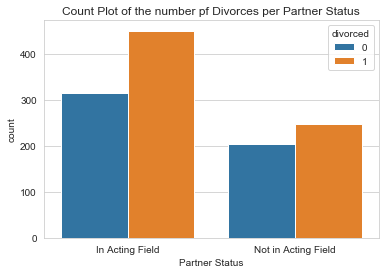

In [107]:
ax = sns.countplot(x=df.partner_in_acting_field.map({0:'Not in Acting Field', 1:'In Acting Field'}), hue = 'divorced', data = df)
ax.set(title = 'Count Plot of the number pf Divorces per Partner Status', 
      xlabel = 'Partner Status')
g = df.groupby('partner_in_acting_field')['divorced'].mean()
g.index = ['Not in Acting Field', 'In Acting Field']
print(f'Percentage of Divorce per Category:\n\n{g}')

##### Effect of Children on Divorce Rates

Text(0, 0.5, 'Percentage of Divorce Cases')

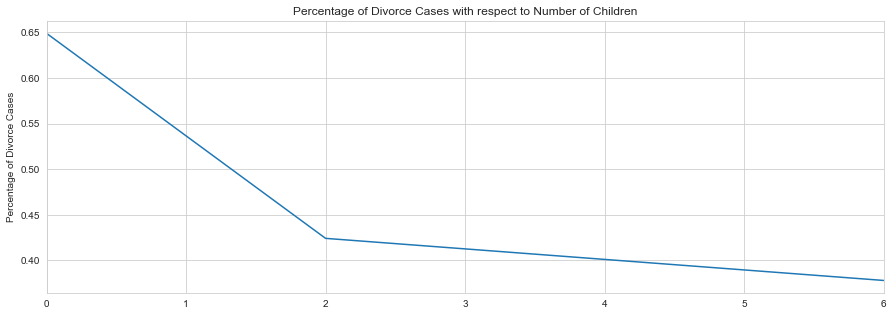

In [113]:
children_binned = pd.cut(df.children, bins = [0,1,2,8], include_lowest = True)
g = df.groupby(children_binned)['divorced'].mean()
g.index = [0,2,6]
fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
g.plot()
plt.title('Percentage of Divorce Cases with respect to Number of Children')
plt.ylabel('Percentage of Divorce Cases')

**Had Divorce Rates changed over time ?**

marriage_date
(1930, 1945]    142
(1945, 1960]    194
(1960, 1975]    182
(1975, 1990]    198
(1990, 2005]    223
(2005, 2020]    194
Name: divorced, dtype: int64


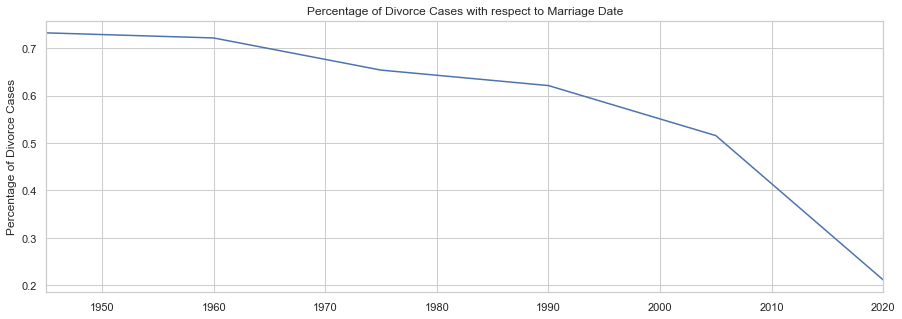

In [135]:
sns.set(style = 'whitegrid',)
bins = np.array(list(range(1930, 2035, 15)))
marriage_date_binned = pd.cut(df.marriage_date, bins = bins)
g = df.groupby(marriage_date_binned)['divorced'].mean()
g.index = bins[1:] 
fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
g.plot()
plt.title('Percentage of Divorce Cases with respect to Marriage Date')
plt.ylabel('Percentage of Divorce Cases')
print(df.groupby(marriage_date_binned)['divorced'].count())

It seems that there has been a huge shift in the divorce rates over time. With Divorce rates decreasing in non-linear rate between 1950 and 2020. Starting at 73% before 1950 moving to 21% near 2020.

##### Effect of Marriage Age on Divorce Rates

In [119]:
def bin_num(x):
    bins = [x.quantile(0), x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), x.quantile(1)]
    return bins
    

Text(0, 0.5, 'Percentage of Divorce Cases')

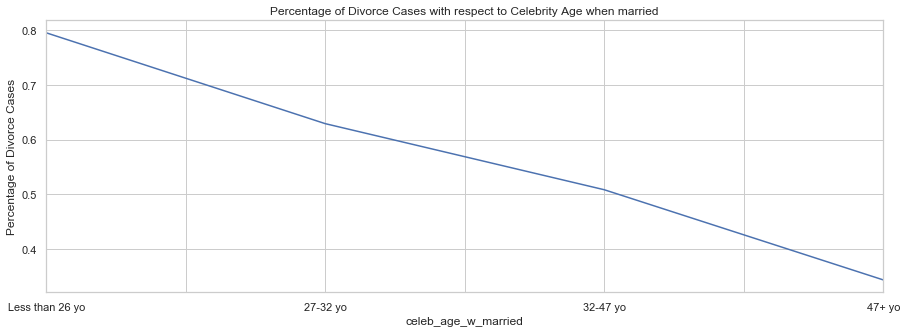

In [120]:
celeb_age_w_married_binned = pd.cut(df.celeb_age_w_married, bins = bin_num(df.celeb_age_w_married), include_lowest = True,
                                   labels = ['Less than 26 yo', '27-32 yo', '32-47 yo', '47+ yo'])
df.groupby(celeb_age_w_married_binned)['divorced'].mean().plot(figsize = (15,5))
plt.title('Percentage of Divorce Cases with respect to Celebrity Age when married')
plt.ylabel('Percentage of Divorce Cases')


The older celebrity marries the less likely his/her marriage end with a divorce.

##### Effect of Age Gap on Divorce Rates

Text(0, 0.5, 'Percentage of Divorce Cases')

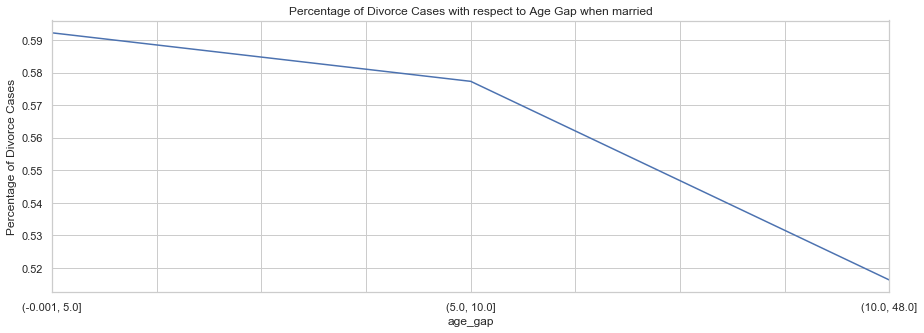

In [127]:
age_gap_binned = pd.cut(df.age_gap, bins = [0,5,10, 48 ], include_lowest = True)
df.groupby([age_gap_binned])['divorced'].mean().plot(figsize = (15,5))
plt.title('Percentage of Divorce Cases with respect to Age Gap when married')
plt.ylabel('Percentage of Divorce Cases')

We don't see much difference in divorce rates except between the very large age gap (10-48) years compared to the smallest one of (0-5). But that doesn't neccessairly imply that these age gaps contribute to more successful marriages as most of these marriages didn't end with a divorce due to the death of the older partner.

In [129]:
df.groupby([age_gap_binned, 'male_older'])['divorced'].count()

age_gap        male_older
(-0.001, 5.0]  0             437
               1             105
(5.0, 10.0]    0             398
               1              61
(10.0, 48.0]   0              85
               1             130
Name: divorced, dtype: int64

##### Distribution of Features with respect to Target variable

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

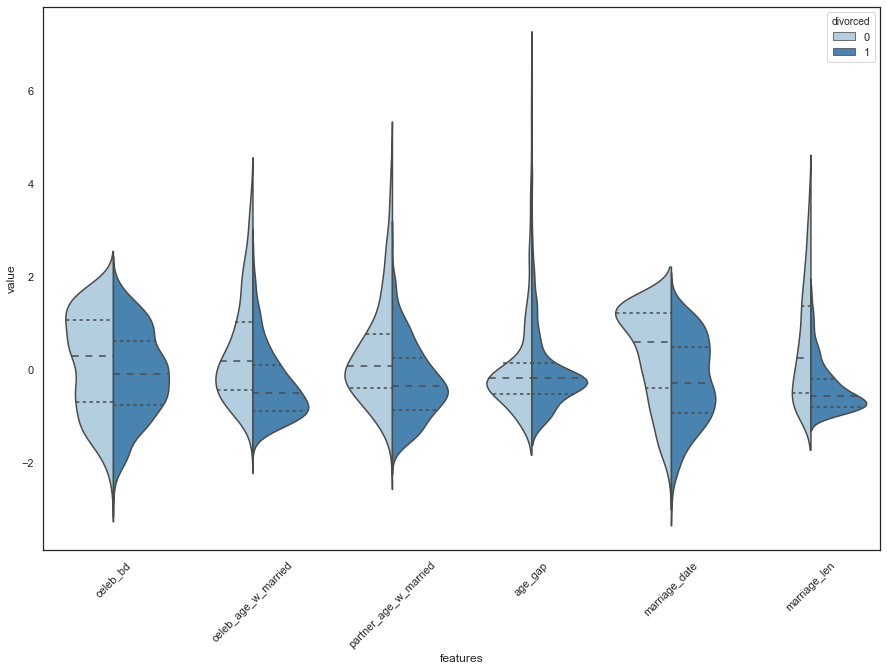

In [130]:
data = x_num
data_std = (data - data.mean()) / data.std()
data = pd.concat([y, data_std], axis = 1)
data = pd.melt(data, id_vars = 'divorced', var_name = 'features', value_name = 'value')
fig_dims = (15, 10)
sns.set(style = 'white',)
fig, ax = plt.subplots(figsize=fig_dims)
sns.violinplot(x = 'features', y = 'value', hue = 'divorced', data = data, ax = ax,  split = True, inner = 'quart', palette = 'Blues')
plt.xticks(rotation = 45)

##### Test Separability of features

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

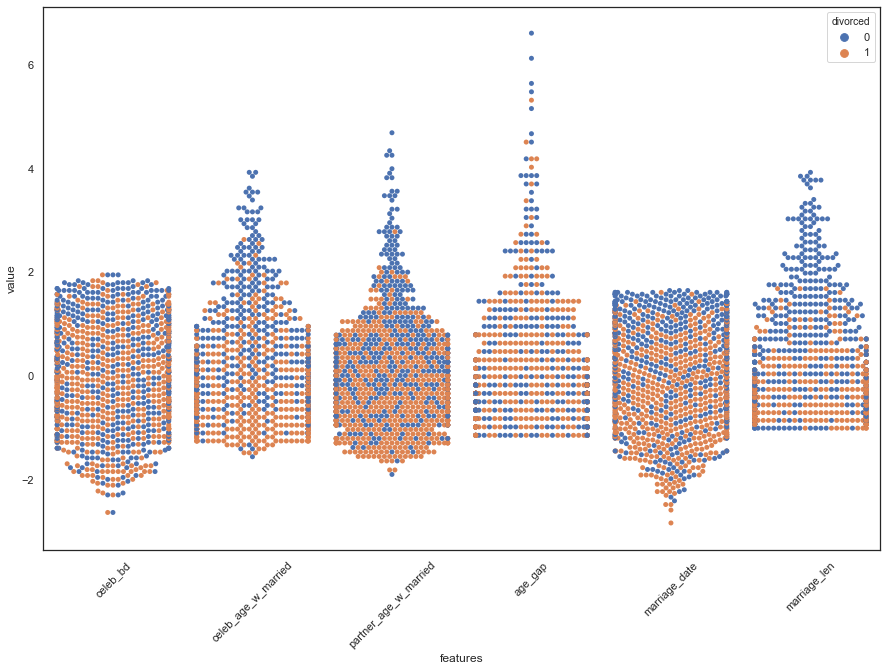

In [131]:
data = x_num
data_std = (data - data.mean()) / data.std()
data = pd.concat([y, data_std], axis = 1)
data = pd.melt(data, id_vars = 'divorced', var_name = 'features', value_name = 'value')
fig_dims = (15, 10)
sns.set(style = 'white',)
fig, ax = plt.subplots(figsize=fig_dims)
sns.swarmplot(x = 'features', y = 'value', hue = 'divorced', data = data, ax = ax)
plt.xticks(rotation = 45)


* We see big correlation between Celebrity and partner ages when married.
* Age Gap doesn't show much difference in quantiles' values between divorced and non-divorced distributions; not a good predictor.
* In contrast to marriage_date which show big difference between divorced and non-divorced distribution.

#### Relationship Between Features

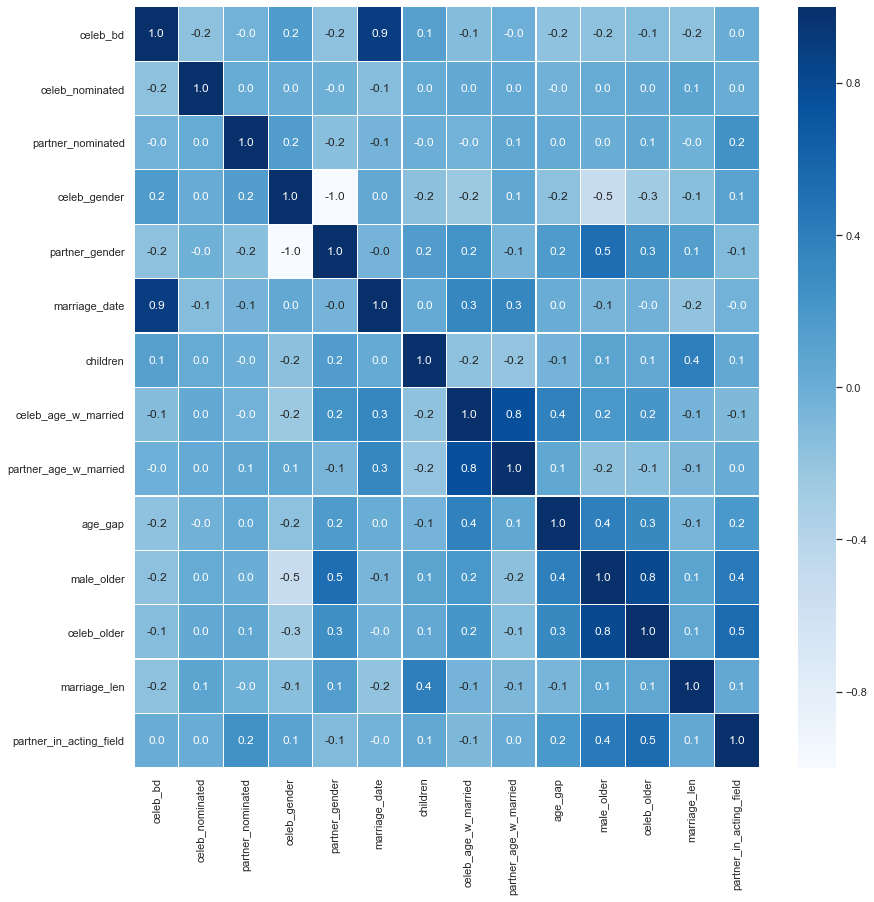

In [132]:
fig, ax = plt.subplots(figsize = (14,14) )
sns.heatmap(x.corr(), annot = True, linewidths = 0.2 , fmt = '.1f', ax =ax, cmap = 'Blues')

##### Correlated Features

We can see that median varies significantly in the celebritiy and partner age when married distributions between the divorced and not divorced cases; which imply that these features might be good predictor for divorce, same applies for age gap. We can also note that both the celebrity and partner age when married follow similar distribution which imply strong correlation between the two features.

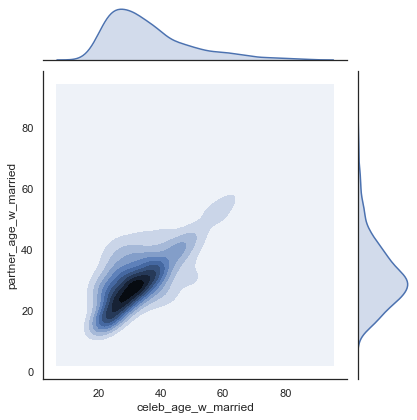

In [133]:
sns.jointplot(x.loc[:, 'celeb_age_w_married'], x.loc[:, 'partner_age_w_married'], kind = 'kde')

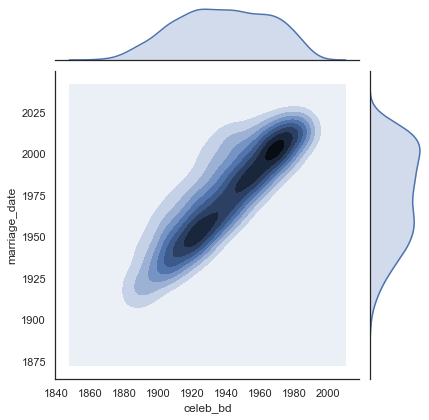

In [134]:
sns.jointplot(x.loc[:, 'celeb_bd'], x.loc[:, 'marriage_date'], kind = 'kde')

We see that aforementioned features are highly correlated, so we'll have to make sure that only one of them goes into our model

# Classification

## Introducing Model

This is a convenient time to introduce the [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression). Logistic regression is a fundamental classification technique. It belongs to the group of [linear classifiers](https://en.wikipedia.org/wiki/Linear_classifier) and is somewhat similar to polynomial and [linear regression](https://en.wikipedia.org/wiki/Linear_regression). When a binary outcome variable is modeled using logistic regression, it is assumed that the [logit transformation](https://en.wikipedia.org/wiki/Logit) of the outcome variable has a linear relationship with the predictor variables.  This makes the interpretation of the regression coefficients somewhat tricky. 


**From probability to odds to log of odds**

  The odds of success are defined as the ratio of the probability of success over the probability of failure.
     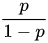
     The transformation from probability to odds is a monotonic transformation, meaning the odds increase as the probability increases or vice versa.  Probability ranges from 0 and 1.  Odds range from 0 and positive infinity. 
     
   The transformation from odds to log of odds is the log transformation.  Again this is a monotonic transformation.  That is to say, the greater the odds, the greater the log of odds and vice versa
   
**Why do we take all the trouble doing the transformation from probability to log odds?**

One reason is that it is usually difficult to model a variable which has restricted range, such as probability.  This transformation is an attempt to get around the restricted range problem.  It maps probability ranging between 0 and 1 to log odds ranging from negative infinity to positive infinity.  Another reason is that among all of the infinitely many choices of transformation, the log of odds is one of the easiest to understand and interpret.  This transformation is called logit transformation.

**The Model**

A logistic regression model allows us to establish a relationship between a binary outcome variable and a group of predictor variables.  It models the logit-transformed probability as a linear relationship with the predictor variables.
 

In [206]:
x0 = x.copy()
x0['marriage_date2'] = x['marriage_date'] ** 2

## Split Data Into Train-Test Sets

In [207]:
import sklearn.model_selection as model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(x0, y, train_size=0.75,test_size=0.25, random_state=101)

In [208]:
X_model = pd.concat([X_train, y_train], axis = 1)

## Model Results

In [209]:
formula = 'divorced ~  + C(celeb_nominated) + C(partner_nominated) + C(celeb_gender) + C(celeb_older)  +  children  + C(male_older)*age_gap  + age_gap + celeb_age_w_married + marriage_date+ marriage_date2 '
model = smf.logit(formula, data = X_model).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.528774
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               divorced   No. Observations:                  912
Model:                          Logit   Df Residuals:                      900
Method:                           MLE   Df Model:                           11
Date:                Mon, 13 Jul 2020   Pseudo R-squ.:                  0.2227
Time:                        19:43:05   Log-Likelihood:                -482.24
converged:                       True   LL-Null:                       -620.41
Covariance Type:            nonrobust   LLR p-value:                 8.321e-53
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                  -2693.6111    407.895     -6.604      0.000   -3493.071   -1894.151
C(celeb_nominated)[T.1]        0.0691      0.222      0.311      0.756      -0.367       0.505
C(partner_nominated)[T.1]      0.1259      0.270      0.466      0.641      -0.404       0.656
C(celeb_gender)[T.1]          -0.6928      0.213     -3.259      0.001      -1.110      -0.276
C(celeb_older)[T.1]            0.7064      0.296      2.388      0.017       0.127       1.286
C(male_older)[T.1]            -1.0387      0.450     -2.310      0.021      -1.920      -0.157
children                      -0.5733      0.074     -7.707      0.000      -0.719      -0.428
age_gap                        0.0013      0.026      0.050      0.960      -0.050       0.053
C(male_older)[T.1]:age_gap     0.0348      0.033      1.057      0.291      -0.030       0.099
celeb_age_w_married           -0.0928      0.009     -9.816      0.000      -0.111      -0.074
marriage_date                  2.7492      0.414      6.635      0.000       1.937       3.561
marriage_date2                -0.0007      0.000     -6.656      0.000      -0.001      -0.000
==============================================================================================
"""

celeb_nominatedOur main interest here lies in the values presented in the coef column in the model summary table, in this column values are in the form of log-odds which make it little tricky to interpret. But, it's useful to know that positive values are associated with making outcome (divorce) more likely, while negative values make outcome less likely. An example for that is the value for children which negative indicating that marriages that result more children are less likely to end with a divorce.



each estimated coefficient is the expected change in the log odds of having a divorce for a unit increase in the corresponding predictor variable holding the other predictor variables constant at certain value.  Each exponentiated coefficient is the ratio of two odds, or the change in odds in the multiplicative scale for a unit increase in the corresponding predictor variable holding other variables at certain value.

We can interpret the coef values by defining it as the difference in log odds. In other words, for a one-unit increase in the predictor score, the expected change in log odds is the value of coef in model summary table.


**Can we translate this change in log odds to the change in odds?**

Indeed, we can.  The logarithm converts multiplication and division to addition and subtraction. Its inverse, the exponentiation converts addition and subtraction back to multiplication and division.  If we exponentiate both sides of one predictors' equation, we have the following:

$$ exp [log(p  /  (1-p))(celeb-nominated = 1)  – log(p / (1-p))(celeb-nominated = 0)] = 
exp [(log(p / (1-p))(celeb-nominated = 1))     /      exp(log(p / (1-p))(celeb-nominated = 0))] = 
odds(celeb-nominated = 1) / odds(celeb-nominated = 0) = exp(0.1259) = 1.134.  $$
 
 
So we can say for a one-unit increase in the binary celeb_nominated value, we expect to see about 13% increase in the odds of having a divorce.

**Interpretation of an interaction term of two predictor variables**

When a model has interaction term(s) of two predictor variables, it attempts to describe how the effect of a predictor variable depends on the level/value of another predictor variable.  The interpretation of the regression coefficients become more involved.

In the presence of interaction term of male-older by age-gap, we can no longer talk about the effect of age-gap, holding all other variables at certain value, since it does not make sense to fix age-gap and male-olderxage-gap at certain value and still allow male-older change from 0 to 1!

In this simple example where we examine the interaction of a binary variable and a continuous variable, we can think that we actually have two equations: one for male-older and one not.  For female-older (male-older=0), the equation is simply

*logit(p) = log(p/(1-p))= β0 + β2 x age-gap*

For females, the equation is

*logit(p) = log(p/(1-p))= (β0 + β1) + (β2 + β3 ) x age-gap*

Now we can map the logistic regression output to these two equations. So we can say that the coefficient for age-gap is the effect of age-gap when male-older = 0.  More explicitly, we can say that for female-older marriages, a one-unit increase in age-gap yields a change in log odds of 0.0013.  On the other hand, for the male-older marriages, a one-unit increase in age-gap yields a change in log odds of (.0013 + .0030) = 0.0043.  In terms of odds ratios, we can say that for female-older, the odds ratio is exp(.0013)  = 1.001 for a one-unit increase in age-gap and the odds ratio for male older is exp(.0043) = 1.004 for a one-unit increase in age-gap score.  The ratio of these two odds ratios (male over female) turns out to be the exponentiated coefficient for the interaction term of male-older by age-gap: 1.005/1.003 = exp(.0348) = 1.03.


In [210]:
# Use Model to predict divorce cases.
s = model.predict(X_test).apply(lambda x : round(x))

In [211]:
class_err = 1 - ((s^y_test).sum() / len(y_test))
print(f'Model classification Error on Test set is: \n>>> {class_err*100:.2f} %')

Model classification Error on Test set is: 
>>> 75.33 %
